In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

In [2]:
!pip install imbalanced-learn

In [3]:
df = pd.read_csv("y_2020.csv")

C:\Users\dingy\AppData\Local\Temp\ipykernel_17212\1465085523.py:1: DtypeWarning: Columns (1,2,5,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("y_2020.csv")


In [4]:
df.info()
df.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198745 entries, 0 to 198744
Data columns (total 23 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   C_YEAR  198745 non-null  int64 
 1   C_MNTH  198745 non-null  object
 2   C_WDAY  198745 non-null  object
 3   C_HOUR  198745 non-null  object
 4   C_SEV   198745 non-null  int64 
 5   C_VEHS  198745 non-null  object
 6   C_CONF  198745 non-null  object
 7   C_RCFG  198745 non-null  object
 8   C_WTHR  198745 non-null  object
 9   C_RSUR  198745 non-null  object
 10  C_RALN  198745 non-null  object
 11  C_TRAF  198745 non-null  object
 12  V_ID    198745 non-null  object
 13  V_TYPE  198745 non-null  object
 14  V_YEAR  198745 non-null  object
 15  P_ID    198745 non-null  object
 16  P_SEX   198745 non-null  object
 17  P_AGE   198745 non-null  object
 18  P_PSN   198745 non-null  object
 19  P_ISEV  198745 non-null  object
 20  P_SAFE  198745 non-null  object
 21  P_USER  198745 non-null  object
 

C_YEAR    0
V_ID      0
P_USER    0
P_SAFE    0
P_ISEV    0
P_PSN     0
P_AGE     0
P_SEX     0
P_ID      0
V_YEAR    0
V_TYPE    0
C_TRAF    0
C_MNTH    0
C_RALN    0
C_RSUR    0
C_WTHR    0
C_RCFG    0
C_CONF    0
C_VEHS    0
C_SEV     0
C_HOUR    0
C_WDAY    0
C_CASE    0
dtype: int64

In [5]:
# Drop ID and year columns
drop_cols = ['C_YEAR', 'V_ID', 'P_ID', 'C_CASE']
df = df.drop(columns=drop_cols, errors='ignore')

In [6]:
from sklearn.model_selection import train_test_split

y = df['P_ISEV']
X = df.drop(columns=['P_ISEV'])

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train size: {X_train.shape}")
print(f"Validation size: {X_val.shape}")
print(f"Test size: {X_test.shape}")

Train size: (119247, 18)
Validation size: (39749, 18)
Test size: (39749, 18)


In [7]:
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numeric_cols = ['V_YEAR'] 

def replace_fake_missing(df):
    df = df.copy()
    fake_missing_values = ['UU', 'XX', 'U', 'X', 'N', 'NN', 'QQ', 'UUUU', 'XXXX' '*', '**']
    df = df.replace(fake_missing_values, np.nan)
    return df

X_train = replace_fake_missing(X_train)
X_val = replace_fake_missing(X_val)
X_test = replace_fake_missing(X_test)

for col in numeric_cols:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
    
for col in categorical_cols:
    X_train[col] = X_train[col].astype(str)
    X_val[col] = X_val[col].astype(str)
    X_test[col] = X_test[col].astype(str)

In [8]:
X_train.head(10)

,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,V_YEAR,P_SEX,P_AGE,P_PSN,P_SAFE,P_USER
167641,11,1,11,2,2,21,01,1,1,1,18,01,2018.0,M,51,23,02,2
139525,9,4,18,1,02,22,02,1,1,1,01,01,2005.0,F,66,11,02,1
174380,11,4,12,2,2,21,01,1,1,1,18,08,2013.0,M,63,11,02,1
160379,10,5,14,2,02,36,02,1,1,1,18,01,2019.0,nan,nan,11,nan,1
79036,6,2,08,2,1,34,02,1,1,2,02,nan,nan,M,68,99,nan,3
1839,1,1,09,2,01,06,01,1,3,1,18,01,2017.0,M,69,11,nan,1
154671,10,3,13,2,02,36,01,2,1,1,01,01,2001.0,M,38,11,02,1
7621,1,3,07,2,02,35,02,1,2,1,01,01,2017.0,F,24,11,02,1
165837,10,7,02,2,2,22,01,1,1,1,nan,nan,nan,nan,nan,11,nan,nan
187083,12,2,17,2,2,21,01,1,1,1,18,01,2020.0,M,34,11,02,1


In [9]:
fake_y_values = ['N', 'U', 'X']

y_train = y_train.replace(fake_y_values, np.nan)
y_val = y_val.replace(fake_y_values, np.nan)
y_test = y_test.replace(fake_y_values, np.nan)

X_train = X_train[y_train.notna()]
y_train = y_train[y_train.notna()]

X_val = X_val[y_val.notna()]
y_val = y_val[y_val.notna()]

X_test = X_test[y_test.notna()]
y_test = y_test[y_test.notna()]

In [10]:
pseudo_numeric = ['P_AGE', 'P_PSN', 'C_VEHS']
numeric_cols += pseudo_numeric

all_object_cols = X_train.select_dtypes(include='object').columns.tolist()

categorical_cols = list(set(all_object_cols) - set(pseudo_numeric))

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
])

# First version of model:

In [12]:
from sklearn.linear_model import LogisticRegression

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        l1_ratio=0.5,
        multi_class='multinomial',
        max_iter=1000
))
])

In [13]:
model.fit(X_train, y_train)

D:\ANACONDA\envs\cpsc330\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
D:\ANACONDA\envs\cpsc330\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['V_YEAR', 'P_AGE', 'P_PSN',
                                                   'C_VEHS']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['C_WDAY', 'C_RALN', 'C_TRAF',
                                                   'C_HOUR', 'C_RSUR', 'C_MNTH',
                                                   'P_SEX', 'P_USER', 'V_TYPE',
                                                   'P_SAFE', 'V_YEAR', 'C_WTHR',
                                                   'C_RCFG', 'C_CONF'])])),
                ('classifier',
                 LogisticRegression(l1_ratio=0.5, max_iter=1000,
                                    multi_class='multinomial',
                                    penalty='elasticnet', solver='saga'))])

In [15]:
# Extract non-zero coefficients to analyze feature importance

# Extract feature names after preprocessing + get model coefficients
coefs = model.named_steps['classifier'].coef_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
# For each class, get non-zero coefficients and their corresponding features
for class_index, class_coef in enumerate(coefs):
    print(f"\nTop features for class {class_index + 1}:")
    
    non_zero_idx = class_coef != 0
    important_features = [(feature_names[i], class_coef[i]) for i in range(len(class_coef)) if non_zero_idx[i]]
    important_features = sorted(important_features, key=lambda x: abs(x[1]), reverse=True)
    
    for feature, coef in important_features[:15]:  # Show top 15
        print(f"{feature}: {coef:.4f}")


Top features for class 1:
cat__P_USER_3: -2.6310
cat__V_TYPE_22: -1.5825
cat__V_TYPE_09: 1.4965
cat__C_CONF_03: -1.2169
cat__V_TYPE_16: -1.2123
cat__P_USER_2: 1.2087
cat__C_CONF_04: -1.1600
cat__P_USER_nan: 1.1045
cat__P_SAFE_nan: 1.0652
cat__P_USER_1: 1.0454
cat__V_YEAR_1985.0: -0.8634
cat__C_CONF_05: -0.7952
cat__P_SEX_nan: 0.7879
cat__C_RCFG_04: -0.7559
cat__P_SAFE_01: -0.7537

Top features for class 2:
cat__P_USER_3: 1.3299
cat__P_USER_4: 1.0686
cat__V_TYPE_17: 1.0686
cat__C_RSUR_8: 1.0281
cat__P_SEX_F: 0.9637
cat__V_YEAR_1978.0: 0.9486
cat__C_RSUR_7: 0.7901
cat__P_SAFE_12: 0.6506
cat__C_TRAF_05: 0.5497
cat__V_YEAR_1979.0: -0.5253
cat__V_YEAR_1966.0: 0.5140
cat__C_TRAF_15: -0.5118
cat__V_YEAR_1954.0: -0.4959
cat__P_SEX_M: 0.4873
cat__V_YEAR_1986.0: 0.4827

Top features for class 3:
cat__P_SEX_nan: -1.8772
cat__V_TYPE_11: -1.6804
cat__P_SAFE_12: -1.5975
cat__P_SAFE_02: -1.5177
cat__C_CONF_31: 1.4330
cat__C_CONF_34: -1.3276
cat__C_TRAF_04: -1.2707
cat__V_YEAR_1954.0: 1.2255
cat__C_T

Train Accuracy: 0.6804442210136649
Validation Accuracy: 0.6815838543380498

Classification Report (Validation Set):
              precision    recall  f1-score   support

           1       0.65      0.57      0.61     15266
           2       0.70      0.77      0.74     20853
           3       0.00      0.00      0.00       349

    accuracy                           0.68     36468
   macro avg       0.45      0.45      0.45     36468
weighted avg       0.67      0.68      0.67     36468



<Figure size 600x600 with 0 Axes>

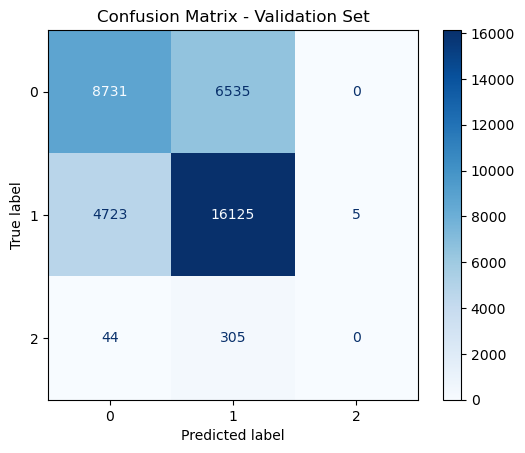

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_val_pred = model.predict(X_val)

print("Train Accuracy:", model.score(X_train, y_train))
print("Validation Accuracy:", model.score(X_val, y_val))

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [19]:
print("Train Accuracy:", model.score(X_train, y_train))
print("Validation Accuracy:", model.score(X_val, y_val))

Train Accuracy: 0.6804442210136649
Validation Accuracy: 0.6815838543380498


# Second Version of model:

In [20]:
X_train_processed = preprocessor.fit_transform(X_train)

In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)

In [22]:
from sklearn.linear_model import LogisticRegression

model_smote = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,
    max_iter=1000
)

model_smote.fit(X_resampled, y_resampled)

LogisticRegression(l1_ratio=0.5, max_iter=1000, penalty='elasticnet',
                   solver='saga')

In [26]:
# Extract non-zero coefficients to analyze feature importance

# Extract feature names after preprocessing + get model coefficients
coefs = model_smote.coef_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

# For each class, get non-zero coefficients and their corresponding features
for class_index, class_coef in enumerate(coefs):
    print(f"\nTop features for class {class_index + 1}:")
    
    non_zero_idx = class_coef != 0
    important_features = [(feature_names[i], class_coef[i]) for i in range(len(class_coef)) if non_zero_idx[i]]
    important_features = sorted(important_features, key=lambda x: abs(x[1]), reverse=True)
    
    for feature, coef in important_features[:15]:  # Show top 15
        print(f"{feature}: {coef:.4f}")


Top features for class 1:
cat__P_USER_3: -2.9342
cat__V_TYPE_09: 2.2037
cat__V_TYPE_22: -2.0204
cat__V_TYPE_11: 1.8388
cat__C_CONF_34: 1.8271
cat__V_TYPE_16: -1.6430
cat__V_YEAR_1954.0: -1.3205
cat__C_CONF_03: -1.2925
cat__C_CONF_04: -1.2841
cat__P_USER_nan: 1.2732
cat__P_USER_2: 1.2585
cat__P_SAFE_nan: 1.2354
cat__C_TRAF_16: -1.2280
cat__P_USER_1: 1.2219
cat__P_SEX_nan: 1.1928

Top features for class 2:
cat__V_YEAR_1969.0: -2.7049
cat__V_YEAR_1954.0: -2.3119
cat__C_RSUR_8: 2.1240
cat__V_YEAR_1978.0: 1.7911
cat__V_YEAR_1932.0: -1.4652
cat__V_TYPE_11: 1.4423
cat__C_TRAF_15: -1.4172
cat__C_CONF_34: 1.3274
cat__V_YEAR_1986.0: 1.3091
cat__C_TRAF_11: 1.1716
cat__C_RALN_Q: 1.1703
cat__C_TRAF_05: 1.1554
cat__P_USER_3: 1.0911
cat__V_YEAR_1966.0: 1.0601
cat__C_RSUR_7: 1.0401

Top features for class 3:
cat__V_YEAR_1954.0: 4.2112
cat__V_TYPE_11: -3.8596
cat__C_CONF_34: -3.7332
cat__V_YEAR_1969.0: 3.6269
cat__V_TYPE_09: -3.3059
cat__C_TRAF_15: 2.8394
cat__C_TRAF_04: -2.6568
cat__P_SEX_nan: -2.644

              precision    recall  f1-score   support

           1       0.60      0.71      0.65     15266
           2       0.73      0.47      0.57     20853
           3       0.05      0.69      0.09       349

    accuracy                           0.57     36468
   macro avg       0.46      0.62      0.44     36468
weighted avg       0.67      0.57      0.60     36468



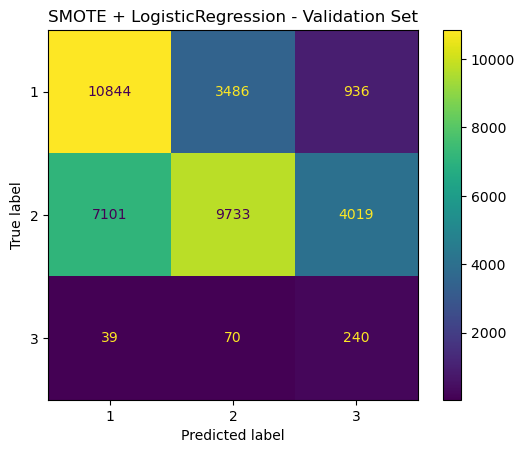

In [27]:
X_val_processed = preprocessor.transform(X_val)

y_val_pred = model_smote.predict(X_val_processed)

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(classification_report(y_val, y_val_pred))

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
plt.title("SMOTE + LogisticRegression - Validation Set")
plt.show()

In [28]:
print("Train Accuracy:", model_smote.score(X_resampled, y_resampled))
print("Validation Accuracy:", model_smote.score(X_val_processed, y_val))

Train Accuracy: 0.6698263505917081
Validation Accuracy: 0.5708292201382034


# Third Version of model:

In [29]:
# Use a pure L1-regularized logistic regression model to observe sparsity

from sklearn.linear_model import LogisticRegression

# Create and fit a pure L1 logistic regression model
model_l1 = LogisticRegression(
    penalty='l1',
    solver='saga',
    multi_class='multinomial',
    max_iter=1000,
    C=1.0  # smaller C makes regularization stronger
)

model_l1.fit(X_resampled, y_resampled)

D:\ANACONDA\envs\cpsc330\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
D:\ANACONDA\envs\cpsc330\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', penalty='l1',
                   solver='saga')

In [30]:
# Extract non-zero coefficients to analyze feature importance

# Extract feature names after preprocessing + get model coefficients
feature_names = preprocessor.get_feature_names_out()
 
coefs = model_l1.coef_  # shape: (n_classes, n_features)

# For each class, get non-zero coefficients and their corresponding features
for class_index, class_coef in enumerate(coefs):
    print(f"\nTop features for class {class_index + 1}:")
    
    non_zero_idx = class_coef != 0
    important_features = [(feature_names[i], class_coef[i]) for i in range(len(class_coef)) if non_zero_idx[i]]
    important_features = sorted(important_features, key=lambda x: abs(x[1]), reverse=True)
    
    for feature, coef in important_features[:15]:  # Show top 15
        print(f"{feature}: {coef:.4f}")


Top features for class 1:
cat__P_USER_3: -3.5612
cat__V_TYPE_22: -2.1182
cat__V_TYPE_09: 1.9368
cat__V_TYPE_16: -1.7609
cat__V_TYPE_11: 1.6256
cat__C_CONF_34: 1.5688
cat__C_CONF_04: -1.4422
cat__C_CONF_03: -1.3760
cat__P_USER_2: 1.2759
cat__P_SAFE_nan: 1.2246
cat__V_YEAR_1970.0: 1.1776
cat__P_USER_nan: 1.1721
cat__P_USER_1: 1.1202
cat__P_USER_5: -1.1034
cat__V_TYPE_14: -1.1034

Top features for class 2:
cat__C_RSUR_8: 2.7111
cat__V_YEAR_1969.0: -2.6588
cat__V_YEAR_1978.0: 2.2962
cat__V_YEAR_1954.0: -2.2435
cat__V_YEAR_1932.0: -1.6203
cat__V_TYPE_11: 1.2354
cat__C_CONF_34: 1.1501
cat__V_YEAR_1966.0: 1.1295
cat__C_RSUR_7: 1.0870
cat__C_WDAY_nan: -1.0739
cat__C_MNTH_nan: -1.0739
cat__V_YEAR_1979.0: -1.0082
cat__V_YEAR_1986.0: 0.9602
cat__C_TRAF_15: -0.9563
cat__V_YEAR_1982.0: 0.8415

Top features for class 3:
cat__V_YEAR_1954.0: 5.3458
cat__V_TYPE_11: -4.8657
cat__C_CONF_34: -4.7243
cat__V_YEAR_1969.0: 4.4407
cat__V_TYPE_09: -4.1319
cat__C_TRAF_15: 3.3206
cat__C_TRAF_04: -3.2996
cat__P_S

              precision    recall  f1-score   support

           1       0.60      0.71      0.65     15266
           2       0.73      0.47      0.57     20853
           3       0.05      0.69      0.09       349

    accuracy                           0.57     36468
   macro avg       0.46      0.62      0.44     36468
weighted avg       0.67      0.57      0.60     36468



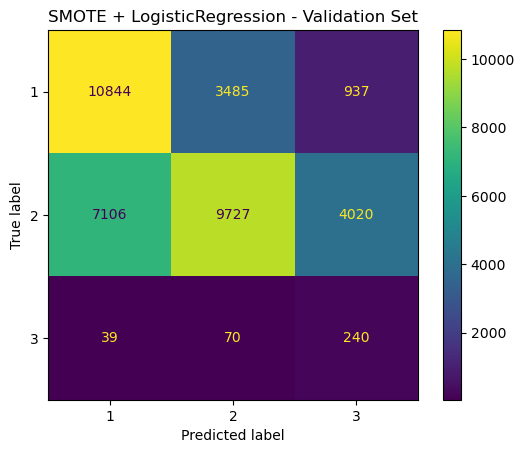

Train Accuracy: 0.6697890524678037
Validation Accuracy: 0.5706646923330043


In [31]:
X_val_processed = preprocessor.transform(X_val)

y_val_pred = model_l1.predict(X_val_processed)

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(classification_report(y_val, y_val_pred))

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
plt.title("SMOTE + LogisticRegression - Validation Set")
plt.show()

print("Train Accuracy:", model_l1.score(X_resampled, y_resampled))
print("Validation Accuracy:", model_l1.score(X_val_processed, y_val))

# Fourth Version of model:

In [32]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

df_second = pd.read_csv("y_2020.csv")

# Filter the dataset to keep only two classes: P_ISEV = 1 or 2
df_second = df_second[df_second['P_ISEV'].isin(['1', '2'])]  # If needed, switch to ['2', '3'] for other binary tasks
df_second['target'] = df_second['P_ISEV'].astype(int)
# Optionally re-label: 0 = minor, 1 = serious
# df['target'] = df['P_ISEV'].apply(lambda x: 0 if x == '1' else 1)

# Select relevant features
selected_features = ['C_MNTH','C_WDAY','C_HOUR','C_SEV','C_VEHS','C_CONF','C_RCFG',
                     'C_WTHR','C_RSUR','C_RALN','C_TRAF','V_TYPE','V_YEAR','P_SEX',
                     'P_AGE','P_PSN','P_SAFE','P_USER']

X = df_second[selected_features]
y = df_second['target']

for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype(str)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define preprocessing for numeric and categorical features
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(exclude='object').columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols)
])

# Build the pipeline with logistic regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', max_iter=1000, solver='lbfgs'))
])

# Train and evaluate the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

C:\Users\dingy\AppData\Local\Temp\ipykernel_17212\4052125092.py:10: DtypeWarning: Columns (1,2,5,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_second = pd.read_csv("y_2020.csv")
C:\Users\dingy\AppData\Local\Temp\ipykernel_17212\4052125092.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(str)
C:\Users\dingy\AppData\Local\Temp\ipykernel_17212\4052125092.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(str)
C:\Users\ding

Accuracy: 0.6986157253599115
              precision    recall  f1-score   support

           1       0.66      0.58      0.62     15267
           2       0.72      0.79      0.75     20853

    accuracy                           0.70     36120
   macro avg       0.69      0.68      0.68     36120
weighted avg       0.70      0.70      0.70     36120



# Trying Future Improvement:

In [33]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

tree_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=15,          min_samples_leaf=200,
        random_state=42
    ))
])

# Train the model
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)

# Evaluate
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Decision Tree Accuracy: 0.6922480620155039
              precision    recall  f1-score   support

           1       0.63      0.66      0.65     15267
           2       0.74      0.71      0.73     20853

    accuracy                           0.69     36120
   macro avg       0.69      0.69      0.69     36120
weighted avg       0.69      0.69      0.69     36120



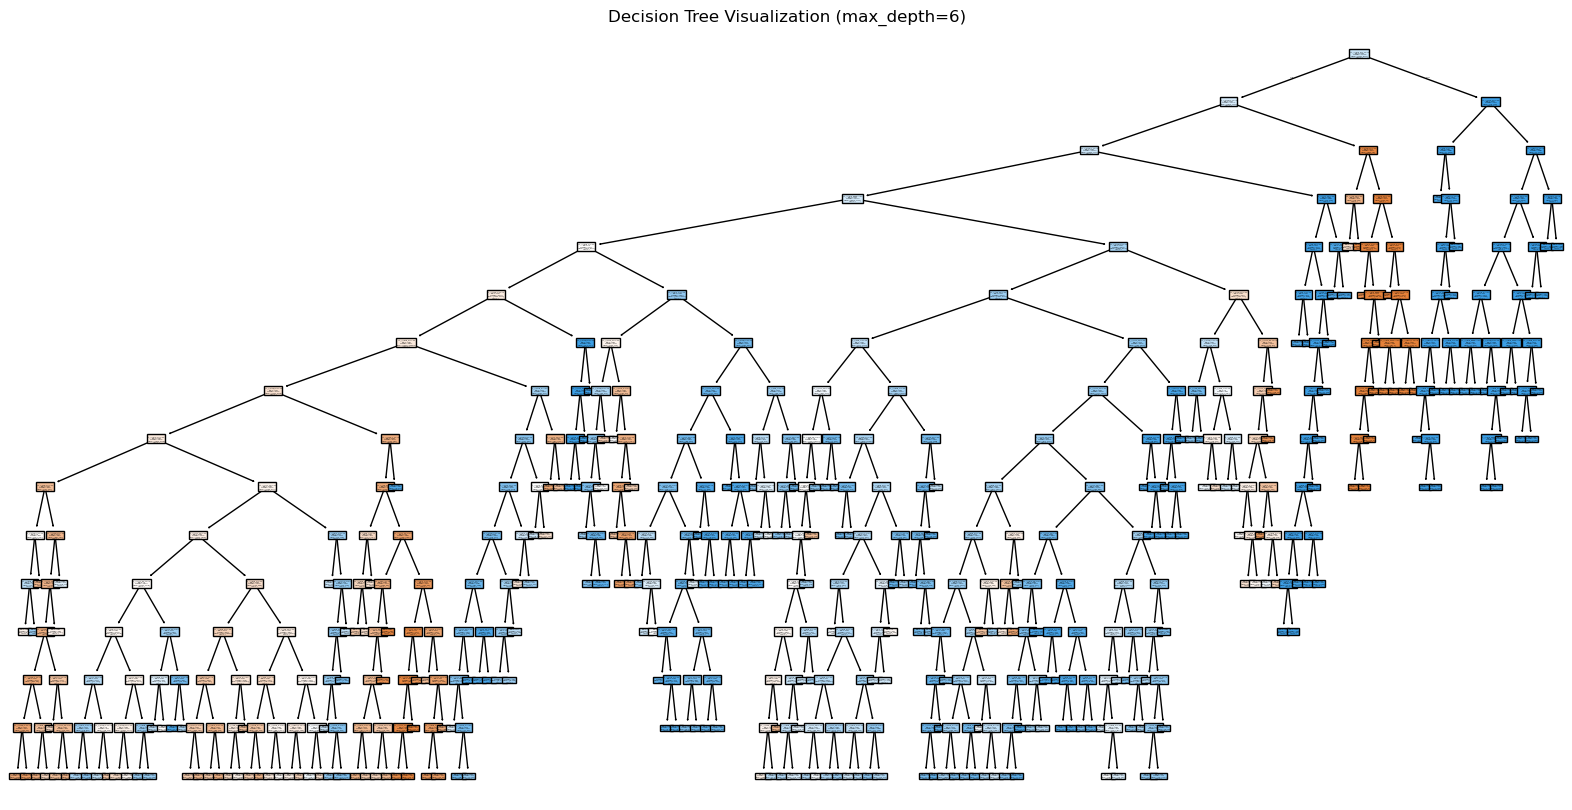

In [34]:
clf = tree_model.named_steps['classifier']

# Fit preprocessing on full dataset for consistent feature names
X_preprocessed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=feature_names, class_names=['1', '2'], filled=True)
plt.title("Decision Tree Visualization (max_depth=6)")
plt.show()